# T2T-ViT

## Configuration

Imports

In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [3]:
DATA_DIR='./data'

IMAGE_SIZE = 32
NUM_CLASSES = 10
NUM_WORKERS = 20
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1
EPOCHS = 100

In [4]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA TITAN V
NVIDIA TITAN V
NVIDIA TITAN RTX
NVIDIA TITAN RTX


In [5]:
DEVICE = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda:2


## Data

In [6]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [7]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

In [9]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

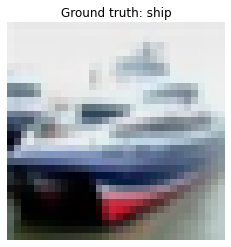

In [10]:
dataset_show_image(test_dset, 1)

## Model

Utilities

In [11]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [12]:
class Residual(nn.Module):
    def __init__(self, *layers, shortcut=None):
        super().__init__()
        self.shortcut = nn.Identity() if shortcut is None else shortcut
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return self.shortcut(x) + self.gamma * self.residual(x)

In [13]:
class TakeFirst(nn.Module):
    def forward(self, x):
        return x[:, 0]

Attention

In [14]:
class SelfAttention(nn.Module):
    def __init__(self, dim, head_dim, heads=8, p_drop=0.):
        super().__init__()
        inner_dim = head_dim * heads
        self.head_shape = (heads, head_dim)
        self.scale = head_dim**-0.5

        self.to_keys = nn.Linear(dim, inner_dim)
        self.to_queries = nn.Linear(dim, inner_dim)
        self.to_values = nn.Linear(dim, inner_dim)
        self.unifyheads = nn.Linear(inner_dim, dim)

        self.drop = nn.Dropout(p_drop)

    def forward(self, x):
        q_shape = x.shape[:-1] + self.head_shape

        keys = self.to_keys(x).view(q_shape).transpose(1, 2) # move head forward to the batch dim
        queries = self.to_queries(x).view(q_shape).transpose(1, 2)
        values = self.to_values(x).view(q_shape).transpose(1, 2)

        att = queries @ keys.transpose(-2, -1)
        att = F.softmax(att * self.scale, dim=-1)
        
        out = att @ values
        out = out.transpose(1, 2).contiguous().flatten(2) # move head back
        out = self.unifyheads(out)
        out = self.drop(out)
        return out

Transformer

In [15]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, mlp_mult=4, p_drop=0.):
        hidden_dim = dim * mlp_mult
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p_drop)
        )

In [16]:
class TransformerBlock(nn.Sequential):
    def __init__(self, dim, head_dim, heads, mlp_mult=4, p_drop=0.):
        super().__init__(
            Residual(nn.LayerNorm(dim), SelfAttention(dim, head_dim, heads, p_drop)),
            Residual(nn.LayerNorm(dim), FeedForward(dim, mlp_mult, p_drop=p_drop))
        )

T2T module

In [17]:
class SoftSplit(nn.Module):
    def __init__(self, in_channels, dim, kernel_size=3, stride=2):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.unfold = nn.Unfold(kernel_size, stride=stride, padding=padding)
        self.project = nn.Linear(in_channels * kernel_size**2, dim)
    
    def forward(self, x):
        out = self.unfold(x).transpose(1, 2)
        out = self.project(out)
        return out

In [18]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
    
    def forward(self, x):
        out = x.transpose(1, 2).unflatten(2, self.shape)
        return out

In [19]:
class T2TBlock(nn.Sequential):
    def __init__(self, image_size, token_dim, embed_dim, heads=1, mlp_mult=1, stride=2, p_drop=0.):
        super().__init__(
            TransformerBlock(token_dim, token_dim // heads , heads, mlp_mult, p_drop),
            Reshape((image_size, image_size)),
            SoftSplit(token_dim, embed_dim, stride=stride)
        )

In [20]:
class T2TModule(nn.Sequential):
    def __init__(self, in_channels, image_size, strides, token_dim, embed_dim, p_drop=0.):
        stride = strides[0]
        layers = [SoftSplit(in_channels, token_dim, stride=stride)]
        image_size = image_size // stride
        
        for stride in strides[1:-1]:
            layers.append(T2TBlock(image_size, token_dim, token_dim, stride=stride, p_drop=p_drop))
            image_size = image_size // stride
        
        stride = strides[-1]
        layers.append(T2TBlock(image_size, token_dim, embed_dim, stride=stride, p_drop=p_drop))
        
        super().__init__(*layers)

T2T-ViT

In [21]:
class PositionEmbedding(nn.Module):
    def __init__(self, image_size, dim):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, image_size**2, dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
    
    def forward(self, x):
        # add positional embedding
        x = x + self.pos_embedding
        # add classification token
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        return x

In [22]:
class TransformerBackbone(nn.Sequential):
    def __init__(self, dim, head_dim, heads, depth, mlp_mult=4, p_drop=0.):
        layers = [TransformerBlock(dim, head_dim, heads, mlp_mult, p_drop) for _ in range(depth)]
        super().__init__(*layers)

In [23]:
class Head(nn.Sequential):
    def __init__(self, dim, classes, p_drop=0.):
        super().__init__(
            nn.LayerNorm(dim),
            nn.Dropout(p_drop),
            nn.Linear(dim, classes)
        )

In [24]:
class T2TViT(nn.Sequential):
    def __init__(self, classes, image_size, strides, token_dim, dim, head_dim, heads, backbone_depth, mlp_mult, 
                 in_channels=3, trans_p_drop=0., head_p_drop=0.):
        reduced_size = image_size // np.prod(strides)
        super().__init__(
            T2TModule(in_channels, image_size, strides, token_dim, dim, p_drop=trans_p_drop),
            PositionEmbedding(reduced_size, dim),
            TransformerBackbone(dim, head_dim, heads, backbone_depth, p_drop=trans_p_drop),
            TakeFirst(),
            Head(dim, classes, p_drop=head_p_drop)
        )

In [25]:
model = T2TViT(NUM_CLASSES, IMAGE_SIZE, strides=[1, 1, 2], token_dim=64, dim=256, head_dim=64, heads=4,
               backbone_depth=8, mlp_mult=2, trans_p_drop=0.3, head_p_drop=0.3)

In [26]:
model.apply(init_linear);

In [27]:
model.to(DEVICE);

In [28]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 6,623,838


## Training

### History

In [29]:
class History:
    def __init__(self):
        self.values = defaultdict(list)

    def append(self, key, value):
        self.values[key].append(value)

    def reset(self):
        for k in self.values.keys():
            self.values[k] = []

    def _begin_plot(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)

    def _end_plot(self, ylabel):
        self.ax.set_xlabel('epoch')
        self.ax.set_ylabel(ylabel)
        plt.show()

    def _plot(self, key, line_type='-', label=None):
        if label is None: label=key
        xs = np.arange(1, len(self.values[key])+1)
        self.ax.plot(xs, self.values[key], line_type, label=label)

    def plot(self, key):
        self._begin_plot()
        self._plot(key, '-')
        self._end_plot(key)

    def plot_train_val(self, key):
        self._begin_plot()
        self._plot('train ' + key, '.-', 'train')
        self._plot('val ' + key, '.-', 'val')
        self.ax.legend()
        self._end_plot(key)

### Optimizer

In [30]:
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, PositionEmbedding)

    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, Residual) and param_name.endswith("gamma"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [31]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = separate_parameters(model)
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

### Setup trainer

In [32]:
loss = nn.CrossEntropyLoss()

In [33]:
optimizer = get_optimizer(model, learning_rate=1e-6, weight_decay=WEIGHT_DECAY)

In [34]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [35]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [36]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [37]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [38]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [39]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [40]:
history = History()

In [41]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history.append('train loss', train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history.append('val loss', val_loss)
    history.append('val acc', val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [42]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/100 - train: loss 1.702; val: loss 1.608 accuracy 0.396
2/100 - train: loss 1.469; val: loss 1.399 accuracy 0.486
3/100 - train: loss 1.396; val: loss 1.244 accuracy 0.550
4/100 - train: loss 1.318; val: loss 1.219 accuracy 0.557
5/100 - train: loss 1.270; val: loss 1.105 accuracy 0.599
6/100 - train: loss 1.286; val: loss 1.090 accuracy 0.611
7/100 - train: loss 1.232; val: loss 1.108 accuracy 0.603
8/100 - train: loss 1.162; val: loss 1.080 accuracy 0.609
9/100 - train: loss 1.144; val: loss 1.023 accuracy 0.639
10/100 - train: loss 1.005; val: loss 0.984 accuracy 0.654
11/100 - train: loss 1.029; val: loss 0.947 accuracy 0.664
12/100 - train: loss 0.992; val: loss 0.901 accuracy 0.674
13/100 - train: loss 1.001; val: loss 0.915 accuracy 0.673
14/100 - train: loss 0.944; val: loss 0.946 accuracy 0.670
15/100 - train: loss 0.951; val: loss 0.818 accuracy 0.711
16/100 - train: loss 0.932; val: loss 0.827 accuracy 0.706
17/100 - train: loss 0.906; val: loss 0.773 accuracy 0.725
18/100

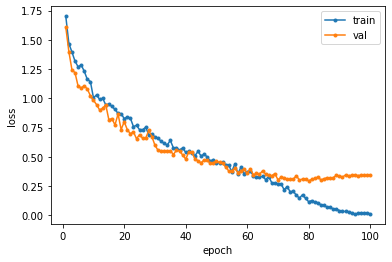

In [43]:
history.plot_train_val('loss')

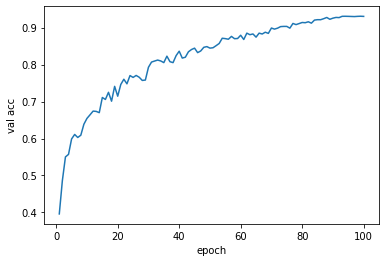

In [44]:
history.plot('val acc')

In [45]:
SAVE_PATH = './models/t2t_weights.pkl'
torch.save(model.state_dict(), SAVE_PATH)